In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)

        self.x = df[['전류(A)', '누적_용량(Ah)', '절대값_용량(Ah)']].values
        # self.x = df.iloc[:, 7:8].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))

        self.y = df.iloc[:, 7:8].values
        
        self.length = len(df)

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [3]:
dataset = CustomDataset("180801_RFB_510cy_006_DC_20000.csv")
print(dataset.x.shape)
print(dataset.x.dtype)
print(dataset.y.shape)
print(dataset.y.dtype)

(20000, 1)
float64
(20000, 1)
float64


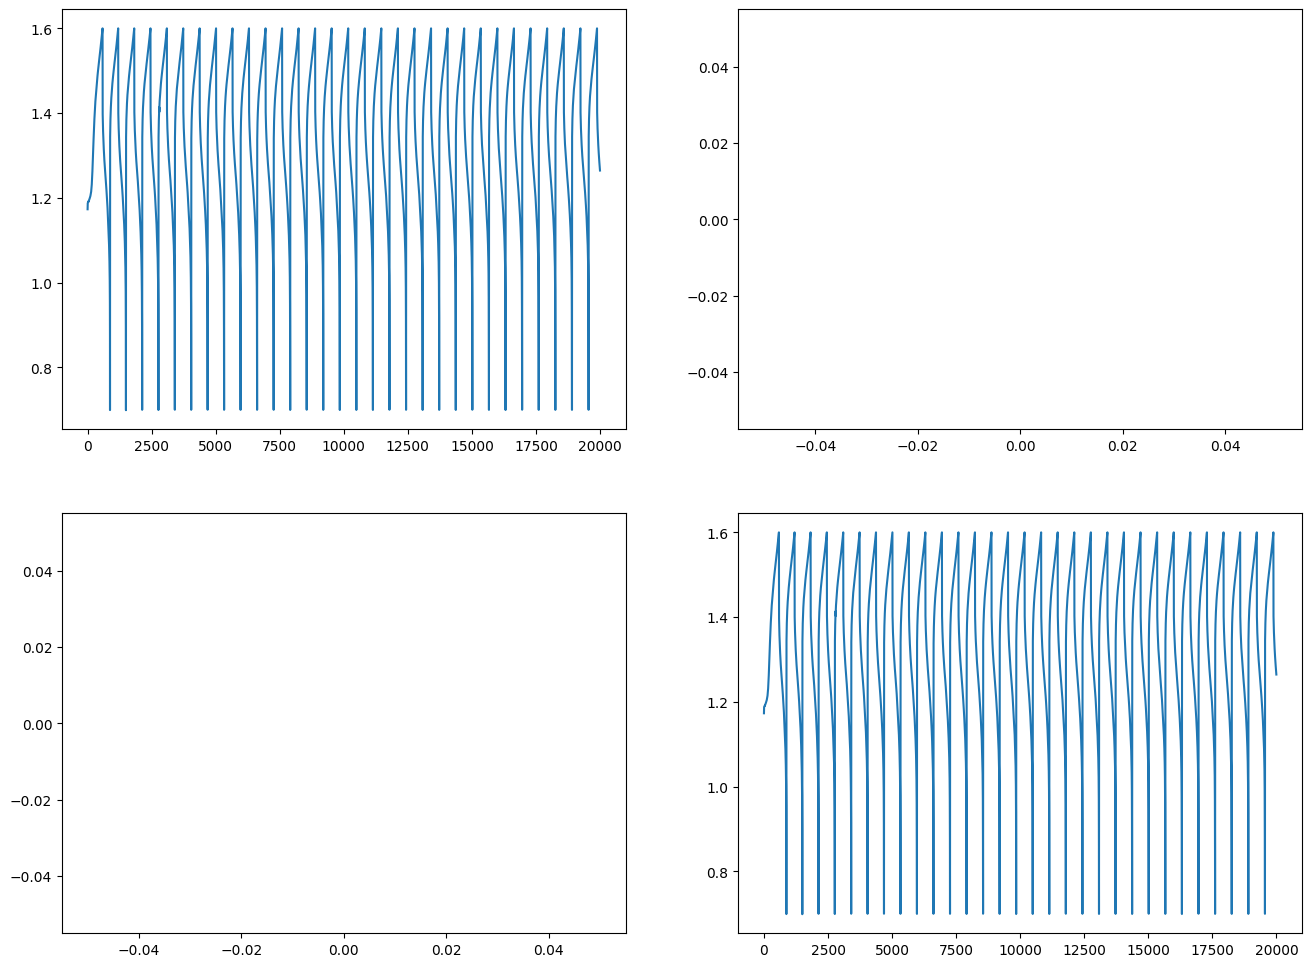

In [4]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.plot(dataset.x[:20000,:1].squeeze())
plt.subplot(2,2,2)
plt.plot(dataset.x[:20000,1:2].squeeze())
plt.subplot(2,2,3)
plt.plot(dataset.x[:20000,2:3].squeeze())
plt.subplot(2,2,4)
plt.plot(dataset.y[:20000].squeeze())
#plt.legend()
plt.show()

In [5]:
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 16000
Validation Data Size : 2000
Testing Data Size : 2000


In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=8, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, drop_last=True)

In [7]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=20000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # div_term = torch.exp(
        #     torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        # )
        div_term = 1 / (10000 ** ((2 * np.arange(d_model)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[0::2])
        pe[:, 1::2] = torch.cos(position * div_term[1::2])

        pe = pe.unsqueeze(0).transpose(0, 1) # [5000, 1, d_model],so need seq-len <= 5000
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        # print(self.pe[:x.size(0), :].repeat(1,x.shape[1],1).shape ,'---',x.shape)
        # dimension 1 maybe inequal batchsize
        return x + self.pe[:x.size(0), :].repeat(1,x.shape[1],1)

In [8]:
class TransAm(nn.Module):
    def __init__(self,feature_size=8,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.input_embedding  = nn.Linear(1,feature_size)
        self.src_mask = None

        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=2, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=feature_size, nhead=2, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        self.ff = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        # src with shape (input_window, batch_len, 1)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src))
            self.src_mask = mask

        src = self.input_embedding(src) # linear transformation before positional embedding
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.transformer_decoder(src,self.src_mask)
        output = self.ff(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [9]:
num_epochs = 150
learning_rate = 0.01

feature_size = 8
num_layers = 2
dropout = 0.1

# num_classes = 1

model = TransAm(feature_size, num_layers, dropout)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
def train_loop(model, dataloader, loss_func, optimizer):
    model.train()
    size = len(dataloader.dataset)
    print("Training")
    running_loss = 0.
    last_loss = 0.

    for batch, (x,y) in tqdm(enumerate(dataloader)):
        pred = model(x)
        loss = loss_func(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [11]:
def test_loop(model, dataloader, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(model, train_dataloader, loss_func, optimizer)
    test_loop(model, test_dataloader, loss_func)
print("Done!")

Epoch 1
-------------------------------
Training


0it [00:00, ?it/s]

loss: 2.603143  [    8/16000]

C:\Users\user\AppData\Local\Temp\ipykernel_14608\1161822840.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  feature = torch.FloatTensor([self.x[index]])
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
6it [00:00, 57.33it/s]

111it [00:01, 66.46it/s]

loss: 0.025419  [  808/16000]


211it [00:03, 61.97it/s]

loss: 0.088867  [ 1608/16000]


310it [00:04, 67.75it/s]

loss: 0.025559  [ 2408/16000]


408it [00:06, 63.34it/s]

loss: 0.043989  [ 3208/16000]


505it [00:08, 54.13it/s]

loss: 0.039598  [ 4008/16000]


610it [00:09, 66.26it/s]

loss: 0.050856  [ 4808/16000]


707it [00:11, 60.35it/s]

loss: 0.014651  [ 5608/16000]


808it [00:13, 51.67it/s]

loss: 0.029222  [ 6408/16000]


904it [00:15, 47.63it/s]

loss: 0.044815  [ 7208/16000]


1009it [00:16, 54.28it/s]

loss: 0.032603  [ 8008/16000]


1111it [00:18, 57.17it/s]

loss: 0.038759  [ 8808/16000]


1211it [00:20, 57.09it/s]

loss: 0.013464  [ 9608/16000]


1307it [00:22, 56.14it/s]

loss: 0.015469  [10408/16000]


1411it [00:24, 54.41it/s]

loss: 0.041602  [11208/16000]


1508it [00:26, 50.70it/s]

loss: 0.031756  [12008/16000]


1604it [00:27, 57.56it/s]

loss: 0.083083  [12808/16000]


1707it [00:29, 57.43it/s]

loss: 0.059616  [13608/16000]


1810it [00:31, 55.35it/s]

loss: 0.106683  [14408/16000]


1906it [00:33, 55.12it/s]

loss: 0.058135  [15208/16000]


2000it [00:35, 56.78it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.041232 

Epoch 2
-------------------------------
Training


6it [00:00, 57.24it/s]

loss: 0.033072  [    8/16000]


108it [00:02, 53.25it/s]

loss: 0.023882  [  808/16000]


210it [00:03, 53.70it/s]

loss: 0.103460  [ 1608/16000]


311it [00:05, 53.44it/s]

loss: 0.032599  [ 2408/16000]


407it [00:07, 52.27it/s]

loss: 0.046417  [ 3208/16000]


509it [00:09, 49.00it/s]

loss: 0.037535  [ 4008/16000]


605it [00:11, 46.54it/s]

loss: 0.045449  [ 4808/16000]


706it [00:13, 47.80it/s]

loss: 0.035050  [ 5608/16000]


807it [00:15, 48.98it/s]

loss: 0.031760  [ 6408/16000]


908it [00:17, 49.16it/s]

loss: 0.021710  [ 7208/16000]


1009it [00:19, 48.79it/s]

loss: 0.034175  [ 8008/16000]


1110it [00:21, 47.98it/s]

loss: 0.043236  [ 8808/16000]


1208it [00:23, 47.72it/s]

loss: 0.022632  [ 9608/16000]


1309it [00:25, 47.32it/s]

loss: 0.017254  [10408/16000]


1409it [00:27, 49.52it/s]

loss: 0.035793  [11208/16000]


1510it [00:29, 49.24it/s]

loss: 0.031567  [12008/16000]


1609it [00:31, 50.02it/s]

loss: 0.046165  [12808/16000]


1710it [00:33, 49.90it/s]

loss: 0.054069  [13608/16000]


1810it [00:35, 51.02it/s]

loss: 0.109150  [14408/16000]


1910it [00:37, 50.45it/s]

loss: 0.032902  [15208/16000]


2000it [00:39, 50.20it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.049650 

Epoch 3
-------------------------------
Training


6it [00:00, 52.06it/s]

loss: 0.050333  [    8/16000]


106it [00:02, 50.60it/s]

loss: 0.023939  [  808/16000]


208it [00:04, 46.36it/s]

loss: 0.064511  [ 1608/16000]


302it [00:06, 51.97it/s]

loss: 0.024072  [ 2408/16000]


407it [00:08, 46.26it/s]

loss: 0.042446  [ 3208/16000]


508it [00:10, 46.18it/s]

loss: 0.037389  [ 4008/16000]


608it [00:12, 46.86it/s]

loss: 0.043255  [ 4808/16000]


709it [00:14, 46.69it/s]

loss: 0.033848  [ 5608/16000]


810it [00:16, 47.57it/s]

loss: 0.027885  [ 6408/16000]


910it [00:18, 47.93it/s]

loss: 0.024507  [ 7208/16000]


1006it [00:20, 47.30it/s]

loss: 0.031551  [ 8008/16000]


1107it [00:22, 50.10it/s]

loss: 0.042562  [ 8808/16000]


1207it [00:24, 49.60it/s]

loss: 0.023032  [ 9608/16000]


1306it [00:26, 50.77it/s]

loss: 0.013525  [10408/16000]


1407it [00:28, 50.50it/s]

loss: 0.034268  [11208/16000]


1509it [00:30, 48.04it/s]

loss: 0.031386  [12008/16000]


1610it [00:32, 48.49it/s]

loss: 0.035484  [12808/16000]


1705it [00:34, 46.23it/s]

loss: 0.041883  [13608/16000]


1806it [00:36, 48.85it/s]

loss: 0.088299  [14408/16000]


1907it [00:38, 49.97it/s]

loss: 0.029176  [15208/16000]


2000it [00:40, 49.29it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.042072 

Done!


In [13]:
X = torch.Tensor(dataset.x)
X1 = torch.reshape(X, (X.shape[0], 1, X.shape[1]))


Y = torch.Tensor(dataset.y)

train_predict = model(X1)
predicted = train_predict.data.numpy()
#(20000, 1, 1)

predicted = predicted.squeeze()
predicted.shape


(20000,)